In [145]:
from imports import *

In [146]:
def discard_border(state,t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)

In [147]:
def firing_rates_intervals(neurons,intervals,nbins):
    if len(intervals) == 0:
        firing_rates = np.empty(shape = (len(neurons),nbins))
        firing_rates.fill(np.nan)
        return firing_rates

    intervals_activity_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        bin_size = inter.duration(time_units='s')/nbins
        t,binned = bk.compute.binSpikes(neurons,start = s,stop = e,nbins = nbins)
        binned = binned/bin_size

        intervals_activity_matrix.append(binned)
    return np.mean(intervals_activity_matrix,0)

def mean_firing_rates_intervals(neurons,intervals,name = None):
    firing_rates = []
    for n in neurons:
        fr = len(n.restrict(intervals))/intervals.tot_length(time_units = 's')
        firing_rates.append(fr)
    if name is None: name = 'FR'   
    firing_rates = pd.DataFrame(firing_rates,columns=[name])
    return firing_rates

In [148]:
def main(base_folder, local_path, *args, **kwargs):

    nbins = kwargs['nbins']
    min_duration_epoch = kwargs['min_duration']
    time_from_border = kwargs['time_from_border']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    states = bk.load.states(True)
    sleep = states['REM'].union(states['NREM'])

    for s in ['wake','drowsy']: states.pop(s)

    all_average_firing = {}
    for k,state in states.items():
        discard_border(state,time_from_border[k]) # We remove what is close to transition as the sleep scoring might not be perfect
        state = state.drop_short_intervals(min_duration_epoch[k],'s').reset_index(drop = True)
        all_average_firing.update({k:firing_rates_intervals(neurons,state,nbins[k])})

    fr = mean_firing_rates_intervals(neurons,sleep,'FR_sleep')
    metadata = pd.concat((metadata,fr),1)
    return all_average_firing,metadata

def merging(batch_output):
    states_activity = {'REM':[],
                        'NREM':[],
                        'WAKE_HOMECAGE':[]}
    metadata = pd.DataFrame()
    for k,b in batch_output.items():
        metadata = pd.concat((metadata,b[1]))
        for kk,state_activity in b[0].items():
            states_activity[kk].append(state_activity)
    
    for k,state_activity in states_activity.items():
        states_activity[k] = np.vstack(state_activity)
    return states_activity,metadata

def plot(activity,metadata,norm = True,order = None,quintile = False,ax = None,style = '',ylim = (-1,1)):

    if style == '': style = 'k--'
    if norm:
        activity = zscore(activity,1)
    if order == 'fr':
        order = np.argsort(metadata.FR_sleep)
        activity = activity[order,:]
        metadata = metadata.iloc[order]
    if order == 'delta':
        delta = np.mean(activity[:,-11:-1],1) - np.mean(activity[:,0:9],1)
        order = np.argsort(delta)
        activity = activity[order,:]
        metadata = metadata.iloc[order]


    if ax is None: fig, ax = plt.subplots(1,2)
    ax[0].imshow(activity,aspect = 'auto',interpolation = 'None')
    for im in ax[0].get_images():
        im.set_clim(-2,2)
    
    
    if quintile:
        labels = ['Very Low','Low','Medium','High','Very High']
        labels_neurons = pd.qcut(metadata.FR_sleep,5,labels = labels)
        for label in labels:
            ax[1].plot(np.nanmean(activity[labels_neurons == label,:],0))
            ax[1].legend(labels)
    else:
        ax[1].plot(np.nanmean(activity,0),style)    
    ax[1].set_ylim(ylim)

def compute_activity_reg(activity):
    x = np.arange(activity.shape[1])
    x = np.tile(x,activity.shape[0])
    y = activity.flatten()

    # Get rid of nans that could be there
    y_nans = np.isnan(y)
    x = x[~y_nans]
    y = y[~y_nans]

    return scipy.stats.linregress(x,y),x,y

def plot_lin_reg(reg,xmin,xmax,step = 0.1,ax = None,style = ''):
    if ax is None:
        fig,ax = plt.subplots()
    
    x = np.arange(xmin,xmax,0.1)
    y = reg.slope * x + reg.intercept
    ax.plot(x,y,style)

def regress(activity,metadata,quintile,norm):
    if norm:
        activity = zscore(activity,1)
    
    if quintile:
        labels = ['Very Low','Low','Medium','High','Very High']
        labels_neurons = pd.qcut(metadata.FR_sleep,5,labels = labels)
        reg = {}
        x = {} 
        y = {}
        for label in labels:
            reg[label],x[label],y[label] = compute_activity_reg(activity[labels_neurons == label])
    else:
        reg,x,y = compute_activity_reg(activity)
    
    return reg,x,y

In [13]:
kwargs = {'nbins':
          {
              'REM': 60,
              'NREM': 60,
              'WAKE_HOMECAGE': 60
          },
          'min_duration':
          {
              'REM': 50,
              'NREM': 250,
              'WAKE_HOMECAGE': 250
          },
          'time_from_border':
          {'REM': 10,
           'NREM': 20,
           'WAKE_HOMECAGE': 10
           }
          }
batch_output_60, batch_metadata_60 = bk.load.batch(main, **kwargs)
states_activity, metadata = merging(batch_output_60)


100%|██████████| 61/61 [03:29<00:00,  3.43s/it]


Batch finished in 209.2108325958252
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150402', 'Rat11-20150403']
11.475409836065573 %


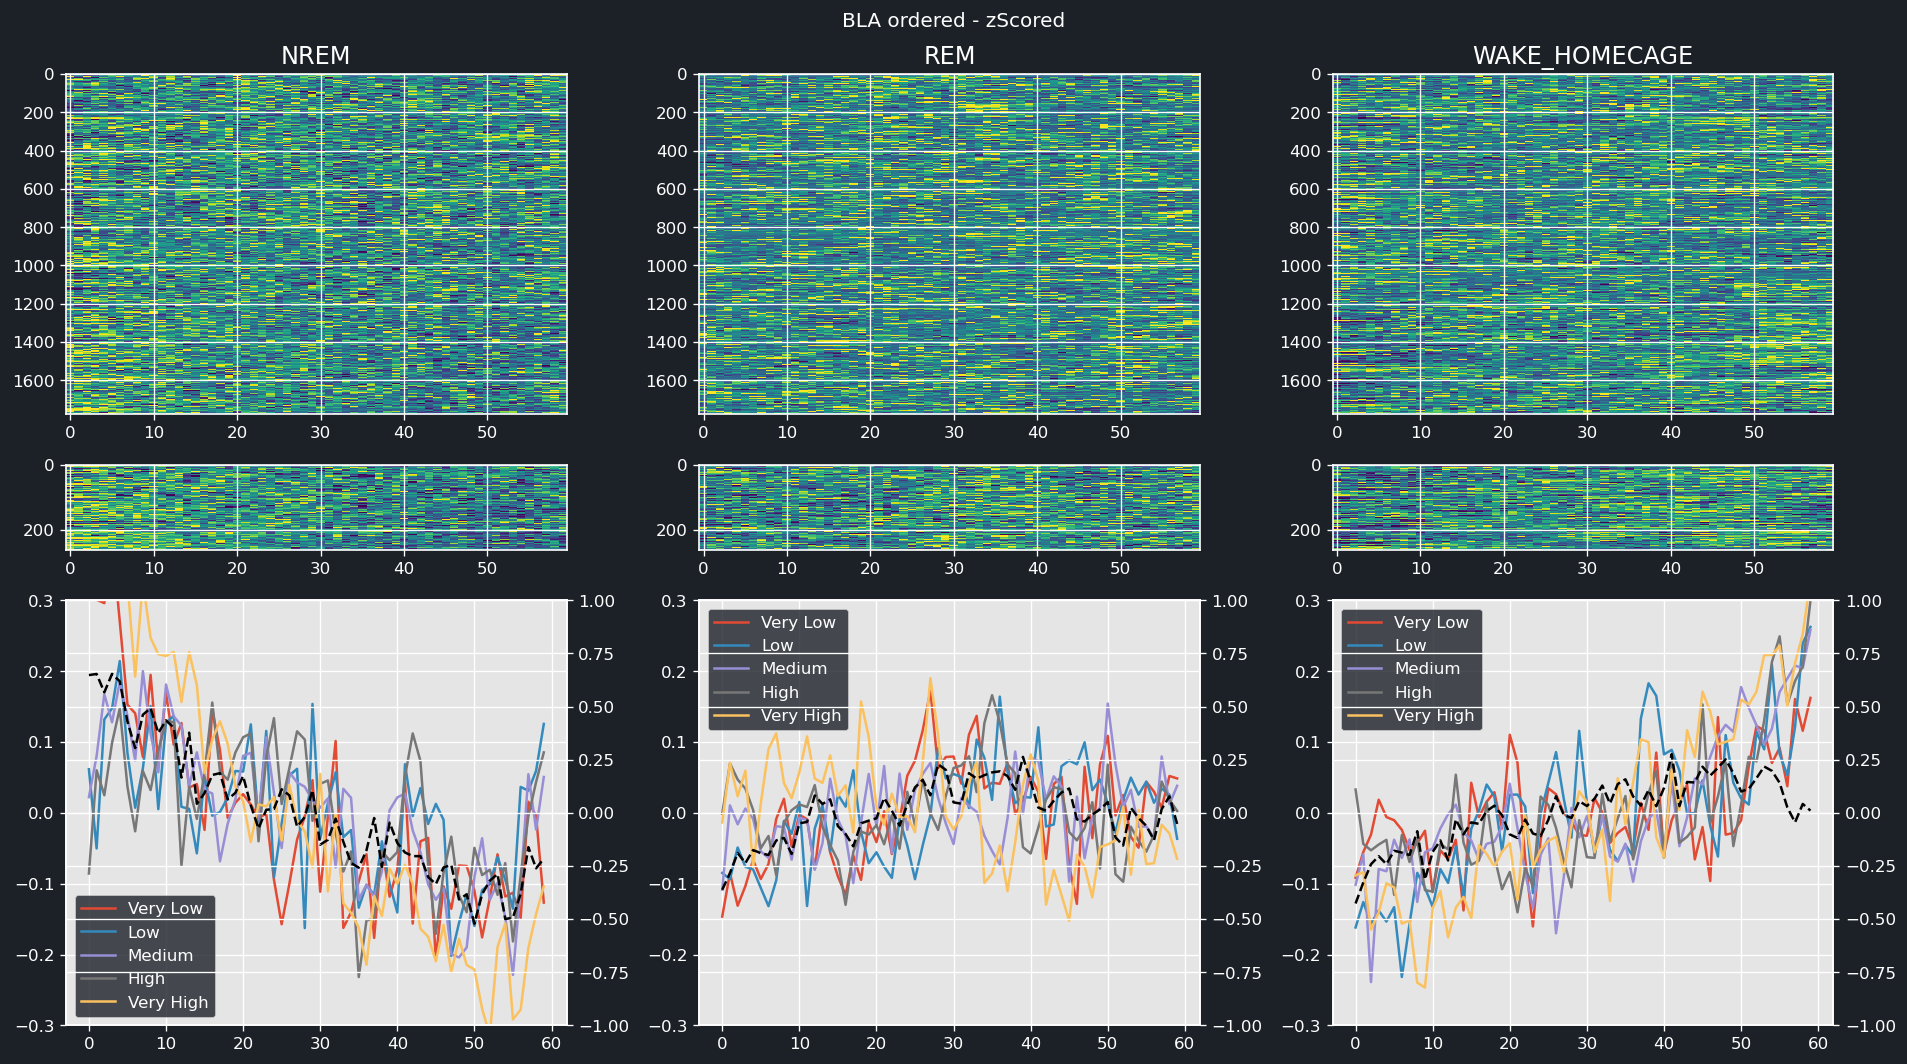

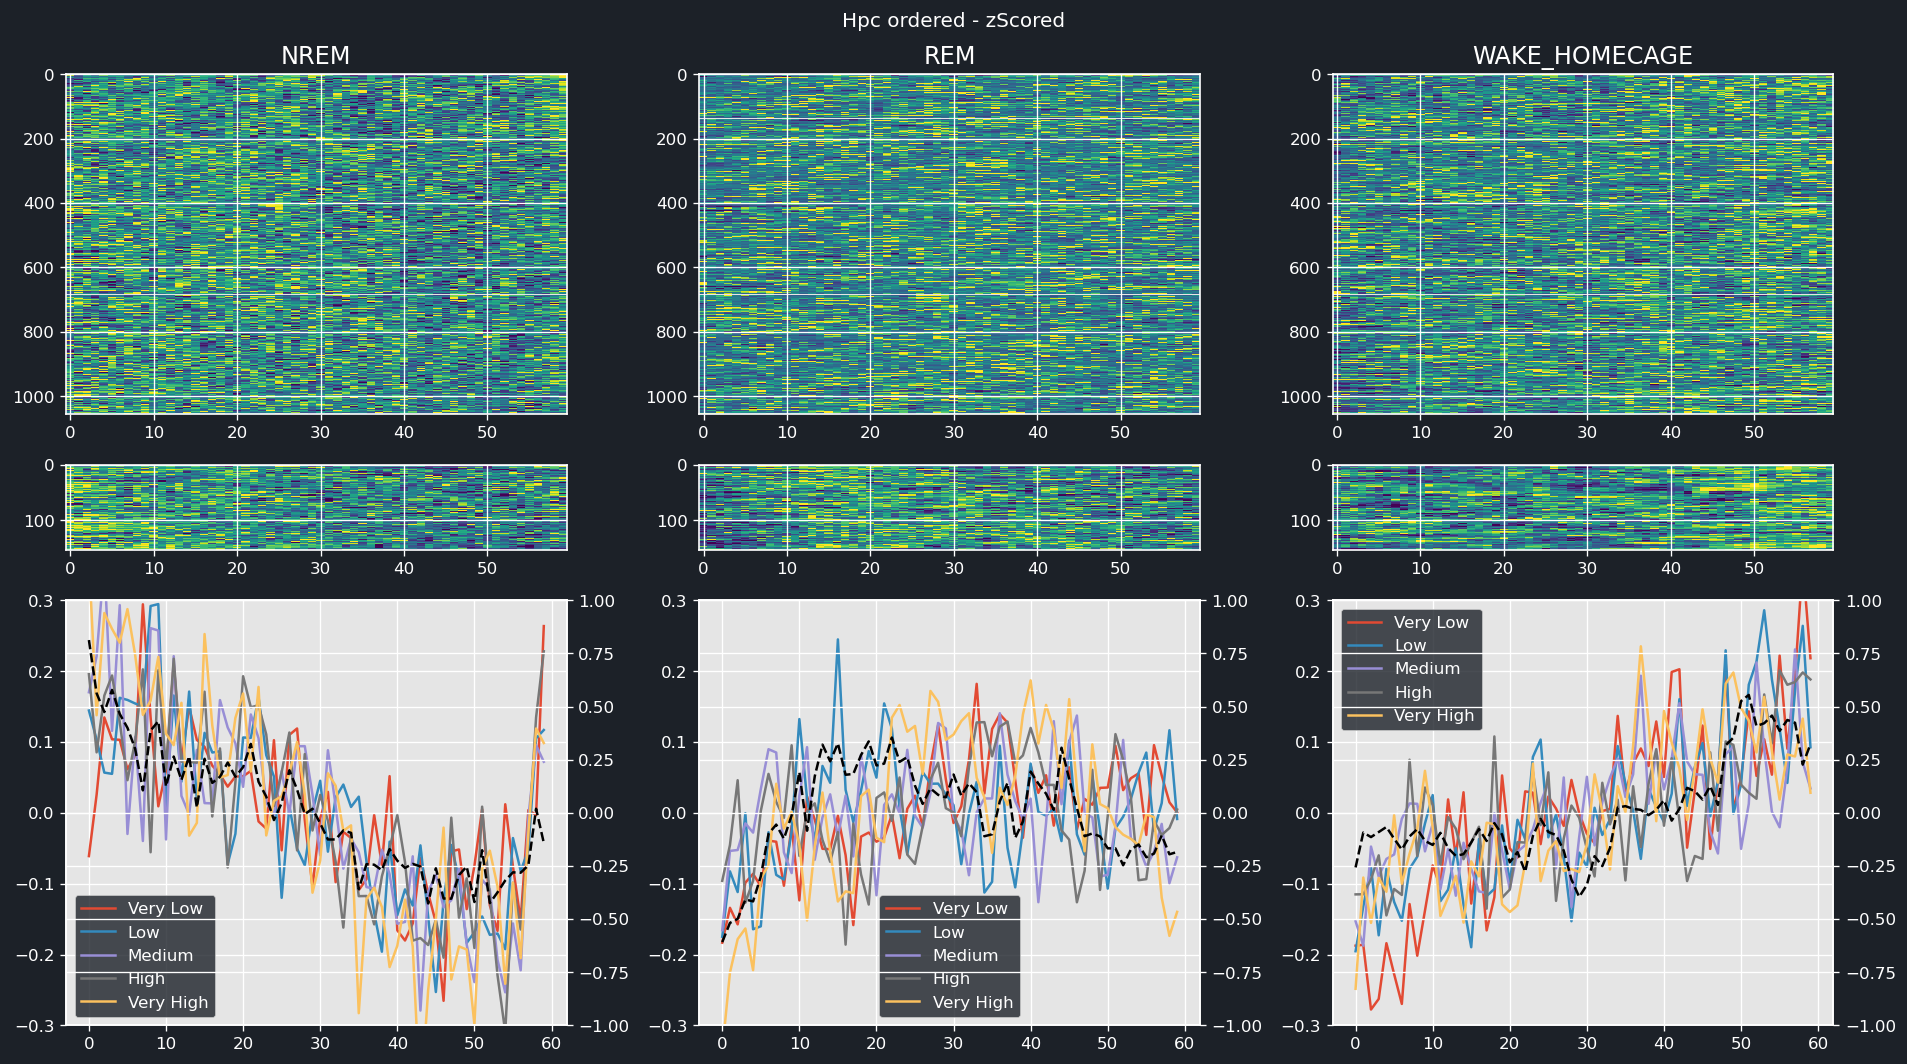

In [14]:
# metadata.Type[metadata.Region == 'CeCM'] = 'Int'
for stru in np.unique(['Hpc','BLA']):
    fig,ax = plt.subplots(3,3,gridspec_kw = {'height_ratios':[4,1,5]},figsize =(16,9),dpi = 120)
    for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
        mask_pyr = (metadata.Region == stru) & (metadata.Type == 'Pyr') 
        mask_int = (metadata.Region == stru) & (metadata.Type == 'Int') 
        ax_int = ax[2,i].twinx()
        if np.any(mask_pyr):
            plot(states_activity[state][mask_pyr],metadata[mask_pyr],
                norm = True,
                order = 'FR',
                quintile = True,
                ax = [ax[0,i],ax[2,i]],
                style = 'g--',
                ylim = [-0.3,0.3])
        if np.any(mask_int):
            plot(states_activity[state][mask_int],metadata[mask_int],
                norm = True,
                order = 'FR',
                quintile = False,
                ax = [ax[1,i],ax_int])

        plt.suptitle(f'{stru} ordered - zScored')
        plt.sca(ax[0,i])
        plt.title(f'{state}')
        plt.tight_layout()
    # plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/states/dynamic/{stru}.svg')
    # plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/states/dynamic/{stru}.png')

# Plot LinReg for each quintiles of Pyr BLA neurons

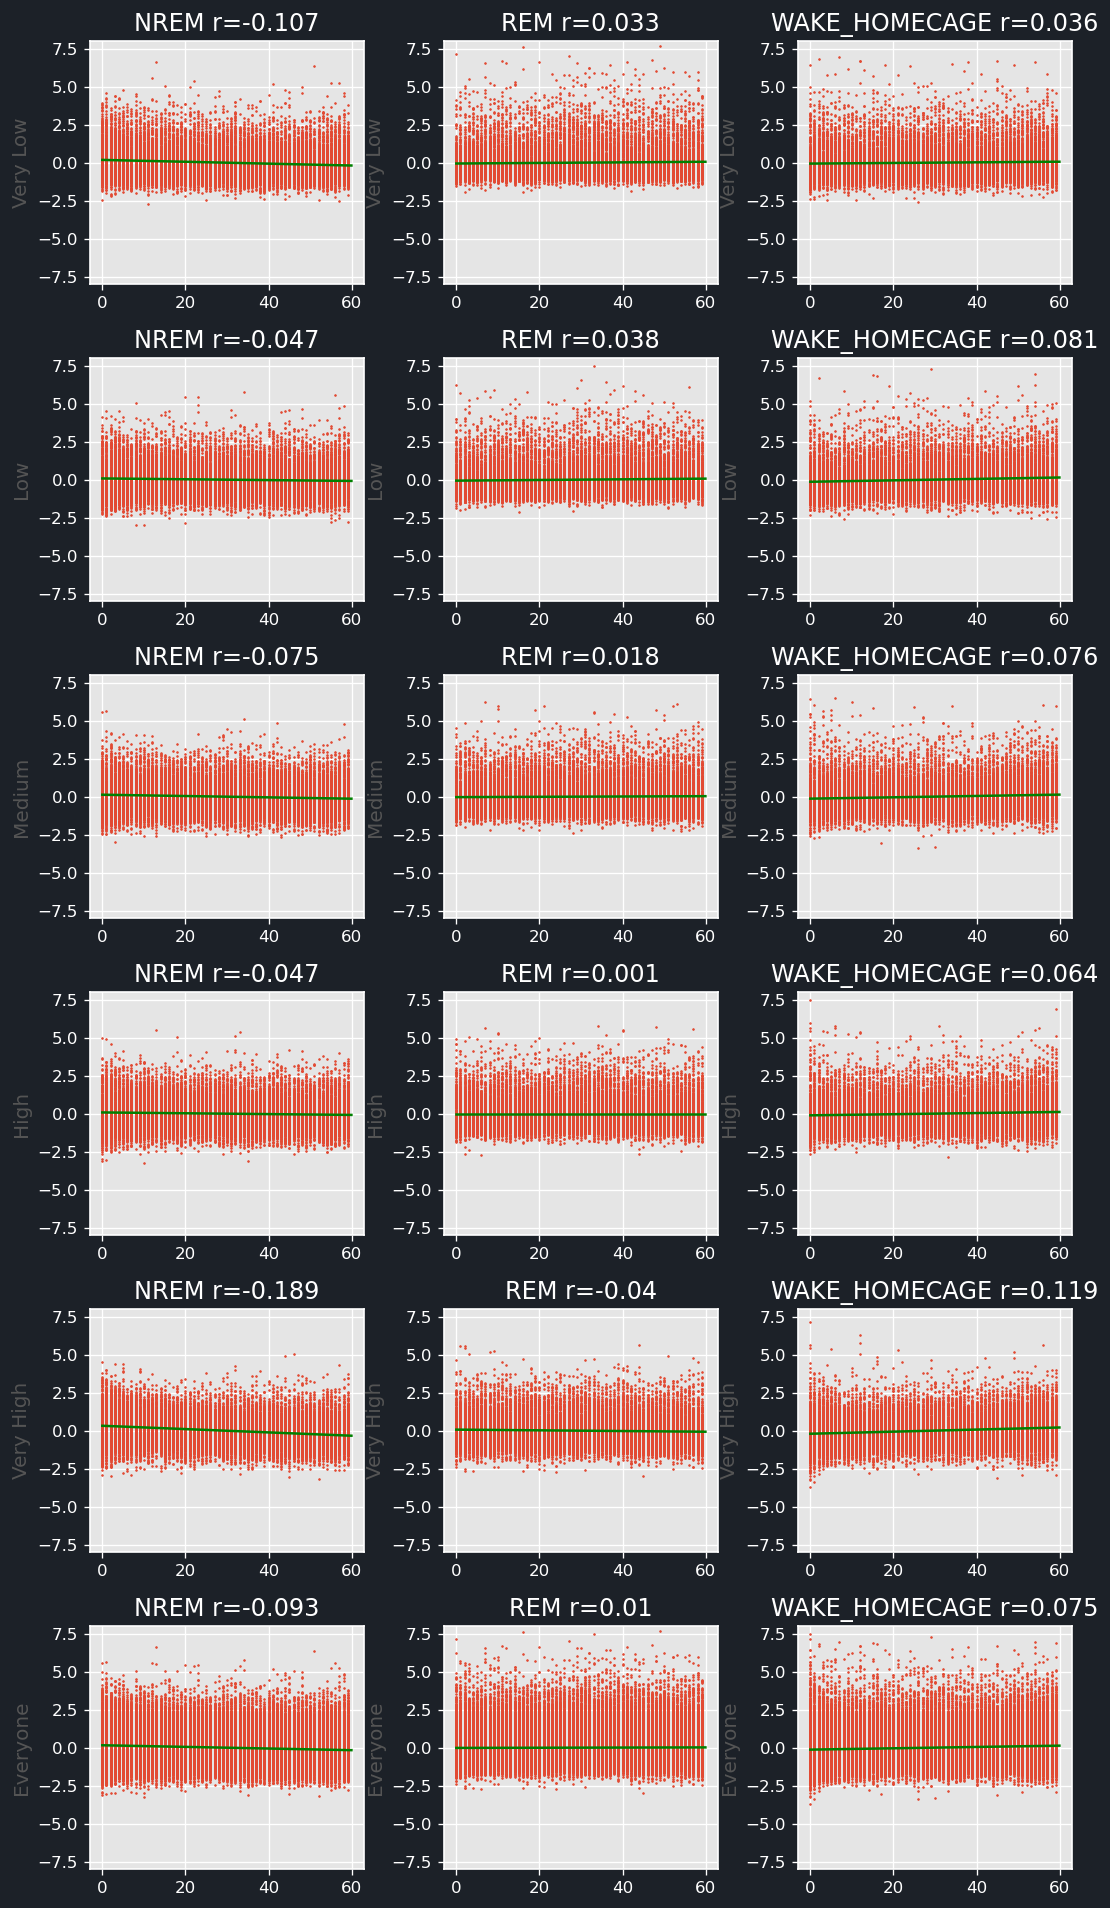

In [144]:
fig,ax = plt.subplots(6,3,figsize =(9,16),dpi = 120) 
stru = 'BLA'
for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    mask_pyr = (metadata.Region == stru) & (metadata.Type == 'Pyr') 
    reg,x,y = regress(states_activity[state][mask_pyr,:],metadata[mask_pyr],True,True)
    for j,q in enumerate(reg):
        ax[j,i].scatter(x[q],y[q],s = 1)
        plot_lin_reg(reg[q],0,60,0.1,ax[j,i],'g')
        ax[j,i].set_ylim(-8,8)
        ax[j,i].set_ylabel(q)
        ax[j,i].set_title(f'{state} r={np.round(reg[q].rvalue,3)}')
    
    reg,x,y = regress(states_activity[state][mask_pyr,:],metadata[mask_pyr],False,True)
    ax[5,i].scatter(x,y,s = 1)
    plot_lin_reg(reg,0,60,0.1,ax[5,i],'g')
    ax[5,i].set_ylim(-8,8)
    ax[5,i].set_ylabel('Everyone')
    ax[5,i].set_title(f'{state} r={np.round(reg.rvalue,3)}')
plt.tight_layout()